<a href="https://colab.research.google.com/github/myresearch-ai/Deep-Learning-CNN-Demo-with-PyTorch/blob/main/1_1_PyTorch_CNN_Tutorial_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. LIBRARIES & MODULES**

In [1]:
# Import PyTorch
import torch
# Import torchvision to get our dataset & useful image transformations
import torchvision
from torchvision.transforms import transforms
# Import PyTorch's optimization library & nn
# nn is used as the basic building block for constructing our network architecture
import torch.optim as optim
import torch.nn as nn
# Import PyTorch's modules for building model
import torch.nn as nn
import torch.nn.functional as F
# Plotting tools
import matplotlib.pyplot as plt

# Check if we are using GPU
print(f"GPU available: {torch.cuda.is_available()}")

GPU available: True


If GPU is available set device = `'cuda'` if not set device = `'cpu'`

In [2]:
if torch.cuda.is_available():
  device = "cuda"
  print("GPU is available & device set to use it.")
else:
  device = "cpu"
  print("GPU is unavailable & device set to cpu.")

GPU is available & device set to use it.


**2. Define The Transformer Pipeline**

In [3]:
# Transform to a PyTorch tensor & normalize values between -1 and +1
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))])

**3. Fetch MNIST data using torchvision**

In [4]:
# Load training data & pass the transform pipeline to preprocess it
trainset = torchvision.datasets.MNIST("mnist",
                                      train = True,
                                      download = True,
                                      transform = transform)

# Load test data & pass the transform pipeline to preprocess it
testset = torchvision.datasets.MNIST("mnist",
                                     train = False,
                                     download = True,
                                     transform = transform)

**4. Visually inspect our data using matplotlib**

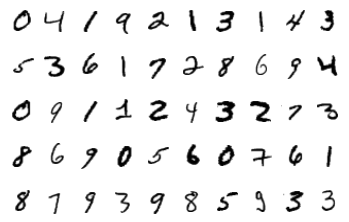

In [5]:
figure = plt.figure()
num_of_images = 50

for index in range(1, num_of_images+1):
  plt.subplot(5, 10, index)
  plt.axis("off")
  plt.imshow(trainset.data[index], cmap = "gray_r")

**5. Create our Data Loader**

In [6]:
# Prepare train & test loader
torch.manual_seed(292)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 128,
                                          shuffle = True,
                                          num_workers = 0)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 128,
                                         shuffle = False,
                                         num_workers = 0)

**6. Build Model**: Subclassing `nn.Module`

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # Define layer objects
    self.conv1 = nn.Conv2d(in_channels = 1, 
                           out_channels = 32, 
                           kernel_size = 5, 
                           padding = 2)
    self.conv2 = nn.Conv2d(in_channels = 32, 
                           out_channels = 64, 
                           kernel_size = 5,
                           padding = 2)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.pool2  = nn.MaxPool2d(kernel_size=2)
    self.fc1   = nn.Linear(3136, 1024)
    self.fc2   = nn.Linear(1024, 10)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    # Define forward propagation sequence
    # Remember it's Conv1 - Relu - Conv2 - Relu - Max Pool - Flatten - FC1 - FC2
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    # Flatten
    x = x.view(-1, 3136)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [9]:
# Create an instance of the model and move it (memory and operations) to the CUDA device
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

**7. Define Loss Function**

In [10]:
criterion = nn.CrossEntropyLoss()
# For our gradient descent algorthim or Optimizer
# We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
# We set the momentum to be 0.9
optimizer = optim.Adam(net.parameters(), lr=0.001)

**8. Training The Model**

In [11]:
def train(model, num_epochs, train_loader, test_loader):
    epoch_log = []
    loss_log  = []
    accuracy_log = []
    
    for epoch in range(num_epochs):
        print(f"Starting Epoch: {epoch + 1}...")
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            #Move our data to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clear gradients before training
            optimizer.zero_grad()
            # Forward -> backprop + optimize
            outputs = model(inputs) # Forward prop
            loss = criterion(outputs, labels) # Get loss
            loss.backward() # Backprop loss
            optimizer.step() # Update gradients

            # Print Training statistics - Epoch/Iterations/Loss/Accuracy
            running_loss += loss.item()
            if i % 50 == 49:
                correct = 0
                total   = 0
                with torch.no_grad():
                    for data in test_loader:
                        images, labels = data
                        # Move our data to GPU
                        images = images.to(device)
                        labels = labels.to(device)
                        # Foward propagate our test data batch through our model
                        outputs = model(images)
                        _, predicted = torch.max(outputs.data, dim = 1)
                        # Keep adding the label size or length to the total variable
                        total += labels.size(0)
                        # Keep a running total of the number of predictions predicted correctly
                        correct += (predicted == labels).sum().item()
                    accuracy = 100 * correct / total
                    epoch_num = epoch + 1
                    actual_loss = running_loss / 50
                    print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                    running_loss = 0.0

        # Store training stats after each epoch
        epoch_log.append(epoch_num)
        loss_log.append(actual_loss)
        accuracy_log.append(accuracy)

    print('Finished Training')

In [12]:
train(model=net, num_epochs=10, train_loader=trainloader, test_loader=testloader)

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 0.692, Test Accuracy = 94.020%
Epoch: 1, Mini-Batches Completed: 100, Loss: 0.175, Test Accuracy = 96.630%
Epoch: 1, Mini-Batches Completed: 150, Loss: 0.117, Test Accuracy = 97.220%
Epoch: 1, Mini-Batches Completed: 200, Loss: 0.095, Test Accuracy = 97.260%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.081, Test Accuracy = 97.920%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.075, Test Accuracy = 98.370%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.067, Test Accuracy = 98.290%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.066, Test Accuracy = 98.510%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.071, Test Accuracy = 98.220%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.057, Test Accuracy = 98.580%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.056, Test Accuracy = 98.390%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.052, Test Accuracy = 98.680%
Epoch: 2, Mini-Batches Completed: 200, Loss: 0.0

**6. Build Model**:`nn.Sequential`

In [13]:
model = nn.Sequential()
model.add_module(
    "conv1",
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)
model.add_module("relu", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module(
    "conv2",
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
model.add_module("flatten", nn.Flatten())
model.add_module("fc1", nn.Linear(3136, 1024))
model.add_module("relu3", nn.ReLU())
model.add_module("dropout", nn.Dropout(p=0.5))
model.add_module("fc2", nn.Linear(1024, 10))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model.cuda()

In [14]:
train(model=model, num_epochs=10, train_loader=trainloader, test_loader=testloader)

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 0.757, Test Accuracy = 93.110%
Epoch: 1, Mini-Batches Completed: 100, Loss: 0.201, Test Accuracy = 95.790%
Epoch: 1, Mini-Batches Completed: 150, Loss: 0.140, Test Accuracy = 96.910%
Epoch: 1, Mini-Batches Completed: 200, Loss: 0.108, Test Accuracy = 97.090%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.098, Test Accuracy = 97.820%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.092, Test Accuracy = 97.580%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.075, Test Accuracy = 98.060%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.073, Test Accuracy = 97.960%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.063, Test Accuracy = 98.150%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.055, Test Accuracy = 98.570%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.051, Test Accuracy = 98.390%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.055, Test Accuracy = 98.230%
Epoch: 2, Mini-Batches Completed: 200, Loss: 0.0